In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm
from tqdm.notebook import tqdm

In [2]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

In [3]:
gi10 = np.load('gittins_10.npy')
gi50 = np.load('gittins_50.npy')
gi100 = np.load('gittins_100.npy')
gi200 = np.load('gittins_200.npy')
gi1000 = np.load('gittins_1000.npy')

In [4]:
n=50
x = 1/np.sqrt(np.arange(1, 2*n-1))

rbf = RBF()
gp = GaussianProcessRegressor(kernel=rbf, alpha=1e-4)
gp.fit(x.reshape(-1,1), gi50.reshape(-1,1))

GaussianProcessRegressor(alpha=0.0001, copy_X_train=True,
                         kernel=RBF(length_scale=1), n_restarts_optimizer=0,
                         normalize_y=False, optimizer='fmin_l_bfgs_b',
                         random_state=None)

In [5]:
x2 = np.linspace(0,1,100).reshape(-1,1) 
pred = gp.predict(x2)

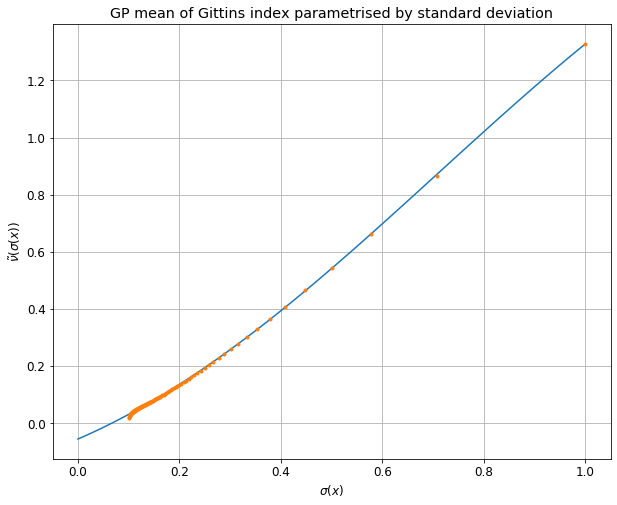

In [7]:
plt.rcParams.update({'font.size':12})
plt.figure(figsize=(10,8))
plt.plot(x2, pred)
plt.plot(1/np.sqrt(np.arange(1, 2*n-1)), gi50, '.')
plt.xlabel(r'$\sigma(x)$')
plt.ylabel(r'$\tilde{\nu}(\sigma(x))$')
plt.grid()
plt.title('GP mean of Gittins index parametrised by standard deviation')
plt.show()

In [7]:
def SE(x1, x2, v, l): # Squared exponential covariance function
    return v ** 2 * np.exp(- 0.5 * (x1[:, None] - x2[None, :]) ** 2 / l ** 2)

In [8]:
class BO:
    def __init__(self, gx=None, gy=None, methods=['cor gittins']):
        if 'cor gittins' in methods:
            self.gx = gx # x values to fit Gittins GP
            self.gy = gy # Gittins values
            self.gp = self.git_gp(gx, gy) # Fit Gittins GP

        self.methods = methods
        
    def set_f(self, ntest):
        kernel = RBF(self.vl[1])
        f = GaussianProcessRegressor(kernel)
        self.fpoints = self.vl[0] * f.sample_y(np.linspace(-1, 1, ntest).reshape(-1,1), random_state=None)
        
        plt.show()
    
    def reward(self, x, ntest):
        idx = np.abs(np.linspace(-1, 1, ntest) - x).argmin()
        
        return np.random.normal(self.fpoints[idx])
        
    
    def git_gp(self, x, gi): # Fit and return Gittins index GP
        gp = GaussianProcessRegressor(kernel=RBF(), alpha=1e-4)
        gp.fit(x.reshape(-1,1), gi.reshape(-1,1))
        return gp
    
    def fit_gp(self, x, y):
        kernel = RBF(length_scale=0.1, length_scale_bounds=(0.1, 10))
        gp = GaussianProcessRegressor(kernel=kernel, alpha=1, n_restarts_optimizer=20) # GP for expected reward
        gp.fit(x.reshape(-1,1), y.reshape(-1,1))
        return gp
              
    def episode(self, n_steps, beta, debug, ntest, nrandom=1):
        actions = {key:np.zeros(n_steps) for key in self.methods}
        rewards = {key:np.zeros(n_steps) for key in self.methods}
        disc_rewards = {key:np.zeros(n_steps) for key in self.methods}
        
        for method in self.methods:
            for step in range(n_steps):
                acts = actions[method][:step]
                rews = rewards[method][:step]

                if method == 'cor gittins':
                    #Kinv = np.linalg.inv(SE(acts, acts, *vl) + np.identity(step))
                    if step < nrandom:
                        action = np.clip(np.random.normal(),-1,1)
                    else:
                        qgp = self.fit_gp(acts, rews)
                        test = np.linspace(-1, 1, ntest)
                        m, cov = qgp.predict(test.reshape(-1,1), return_cov=True)
                        std = np.sqrt(np.diag(cov))
                        b = self.gp.predict(std.reshape(-1,1))
                        m = m.squeeze()
                        b = b.squeeze()
                        if debug:
                            print(acts, rews)
                            plt.figure(figsize=(10,8))
                            plt.plot(test, m, label='m')
                            plt.plot(test, b, label='b')
                            plt.plot(test, m+b,label='index')
                            plt.fill_between(test, m-std,  m+std, alpha=0.5)
                            plt.plot(acts, rews, '.')
                            plt.legend()
                            plt.show()

                        action = test[(m+b).argmax()]
    
                elif method == 'ei':
                    if step < nrandom:
                        action = np.clip(np.random.normal(),-1,1)
                    else:
                        qgp = self.fit_gp(acts,rews)
                        test = np.linspace(-1, 1, ntest)
                        m, cov = qgp.predict(test.reshape(-1,1), return_cov=True)
                        std = np.sqrt(np.diag(cov))
                        m = m.squeeze()
                        p = -(m - rews.max()) / std
                        ei = (m - rews.max()) * norm.cdf(p) + std * norm.pdf(p)
                        if debug:
                            #print(acts, rews)
                            plt.figure(figsize=(10,8))
                            plt.plot(test, m, label='m')
                            plt.plot(test, ei, label='ei')
                            plt.fill_between(test, m-std,  m+std, alpha=0.5)
                            plt.plot(acts, rews, '.')
                            plt.legend()
                            plt.show()
                        
                        action = test[ei.argmax()]
             
                elif method.startswith('ucb'):
                    if step == 0:
                        if isinstance(beta, float) or isinstance(beta, int):
                            b = beta
                        else:
                            b = beta[0]
                            beta = beta[1:]
                    if step < nrandom:
                        action = np.clip(np.random.normal(),-1,1)
                    else:
                        test = np.linspace(-1, 1, ntest)
                        qgp = self.fit_gp(acts, rews)
                        m, cov = qgp.predict(test.reshape(-1,1), return_cov=True)
                        m = m.squeeze()
                        std = np.sqrt(np.diag(cov))
                        ucb = m + b * std
                        if debug:
                            #print(acts, rews)
                            plt.figure(figsize=(10,8))
                            plt.plot(test, m, label='m')
                            plt.plot(test, ucb, label='ucb')
                            plt.fill_between(test, m-std,  m+std, alpha=0.5)
                            plt.plot(acts, rews, '.')
                            plt.legend()
                            plt.show()

                        action = test[ucb.argmax()]
                        
                elif method == 'thompson':
                    if step < nrandom:
                        action = np.clip(np.random.normal(),-1,1)
                    else:
                        qgp = self.fit_gp(acts, rews)
                        test = np.linspace(-1, 1, ntest)
                        samp = qgp.sample_y(test.reshape(-1,1))
                        action = test[samp.argmax()]
                        if debug:
                            m, cov = qgp.predict(test.reshape(-1,1), return_cov=True)
                            m = m.squeeze()
                            std = np.sqrt(np.diag(cov))
                            plt.figure(figsize=(10,8))
                            plt.plot(test, m, label='m')
                            plt.plot(test, samp, label='sample')
                            plt.fill_between(test, m-std,  m+std, alpha=0.5)
                            plt.plot(acts, rews, '.')
                            plt.legend()
                            plt.show()
                
                rew = self.reward(action, ntest)

                actions[method][step] = action                     
                rewards[method][step] = rew
                disc_rewards[method][step] = rew * (1 - 1 / n_steps) ** step
            
                #print(action, rew)
            
            
        return actions, rewards, disc_rewards
        
    def run(self, n_eps, n_steps, vl, maxiter=10, beta=None, debug=False, ntest=200, nrandom=1):
        self.vl = vl
        self.actions = {key:np.zeros((n_eps, n_steps)) for key in self.methods}
        self.rewards = {key:np.zeros((n_eps, n_steps)) for key in self.methods}
        self.disc_rewards = {key:np.zeros((n_eps, n_steps)) for key in self.methods}
        self.fs = np.zeros((n_eps, ntest))
        
        for ep in tqdm(range(n_eps)):
            self.set_f(ntest)
            self.fs[ep, :] = self.fpoints.squeeze()
            a, r, d = self.episode(n_steps, beta, debug, ntest, nrandom)
            for method in self.methods:
                self.actions[method][ep, :] = a[method]
                self.rewards[method][ep, :] = r[method]
                self.disc_rewards[method][ep, :] = d[method]       

In [9]:
n = 50
gx = 1/np.sqrt(np.arange(1, 2*n-1))

bo = BO(gx, gi50, methods=['cor gittins', 'ei', 'ucb 2.1', 'ucb 2.5', 'thompson'])

bo.run(100, n, [1, 2/50], beta=[2.1,2.5], ntest=100, nrandom=1)

In [10]:
cdr = {}
for method in bo.disc_rewards.keys():
    cdr[method] = np.cumsum(bo.disc_rewards[method], axis=1).mean(axis=0)

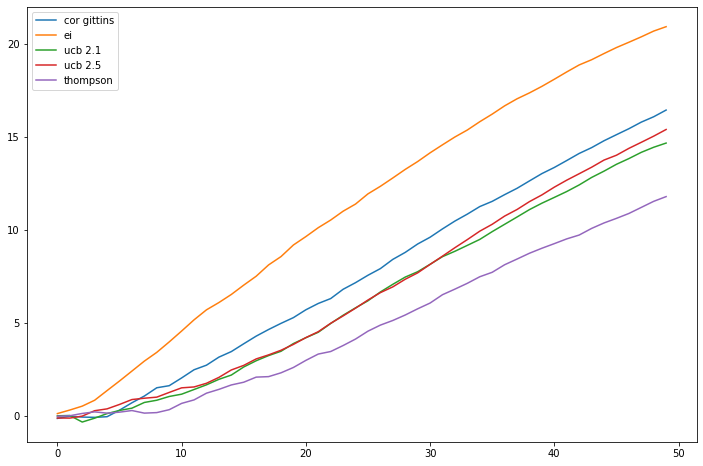

In [11]:
plt.figure(figsize=(12,8))
for method in cdr.keys():
    plt.plot(cdr[method])

plt.legend(cdr.keys())
plt.show()

In [12]:
bests = np.zeros(len(bo.rewards.keys()))
for i in range(n):
    best = np.array([bo.rewards[m][i,:].max() for m in bo.rewards.keys()]).argmax()
    bests[best] += 1
    
print([(m, b/n) for m, b in zip(bo.rewards.keys(), bests)])

[('cor gittins', 0.18), ('ei', 0.2), ('ucb 2.1', 0.22), ('ucb 2.5', 0.2), ('thompson', 0.2)]


In [13]:
for m in bo.disc_rewards.keys():
    print(m, bo.disc_rewards[m].sum(axis=1).mean())

cor gittins 16.450281719954315
ei 20.936823362178988
ucb 2.1 14.674207059368975
ucb 2.5 15.404724245758423
thompson 11.793148725954918


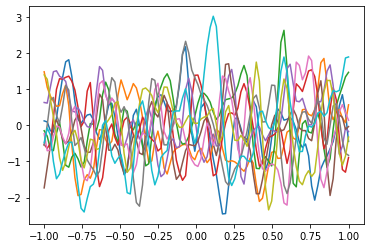

In [14]:
for i in range(10):
    plt.plot(np.linspace(-1,1,100),bo.fs[i,:])

In [15]:
import pickle
import os

In [33]:
dir_str = "2000.n=50.vl=5.1"
if not os.path.exists(dir_str):
    os.mkdir(dir_str)

    with open(os.path.join(dir_str, 'rew.pkl'), "wb") as f:
        pickle.dump(bo.rewards, f)
    with open(os.path.join(dir_str, 'drew.pkl'), "wb") as f:
        pickle.dump(bo.disc_rewards, f)
    with open(os.path.join(dir_str, 'actions.pkl'), "wb") as f:
        pickle.dump(bo.actions, f)
    with open(os.path.join(dir_str, 'fs.pkl'), "wb") as f:
        pickle.dump(bo.fs, f)

